In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib
import seaborn as sns

from scipy import stats
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

sns.set(style='darkgrid')

Using matplotlib backend: MacOSX


In [2]:
df=pd.read_csv('kc_house_data.csv')

In [3]:
df['date'] = pd.to_datetime(df['date'])

In [4]:
df['sale_month'] = df['date'].map(lambda x: x.month)

In [5]:
df=df.drop(['id','date'],axis=1)

In [6]:
# Replace '?' with '0'.
df['sqft_basement']=df['sqft_basement'].map(lambda x:float(x.replace('?', '0')))


In [7]:
#Replace 0 with difference between sqft_above and sqft_living
df['sqft_basement'].replace(to_replace='0', value = abs(df['sqft_living']-df['sqft_above']), inplace=True)


In [8]:
# Change 33 bedrooms to 3 bedrooms.
df['bedrooms'].replace(to_replace=33, value =3, inplace=True)


In [9]:
df['view'].fillna(0,inplace=True)

In [10]:
df['waterfront'].fillna(0,inplace=True)

In [11]:
df.yr_renovated.fillna(0, inplace=True)

In [12]:
Q1 = df.quantile(0.001)
Q3 = df.quantile(0.999)
IQR = Q3 - Q1

df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [13]:
# non_normal = ['price','sqft_living', 'sqft_lot','sqft_above','sqft_basement',
#               'yr_built', 'yr_renovated','sqft_living15', 'sqft_lot15']
# for feat in non_normal:
#     df[feat] = df[feat].map(lambda x: np.log1p(x))


In [14]:
def norm_feat(series):
    return (series - series.mean())/series.std()
for feat in ['bathrooms', 'sqft_living', 'sqft_lot','sqft_above', 'sqft_basement', 'yr_built','yr_renovated','sqft_living15', 'sqft_lot15']:
    df[feat] = norm_feat(df[feat])


In [15]:
df['bedrooms'] = df['bedrooms'].astype('category')
df['floors'] = df['floors'].astype('category')
df['waterfront'] = df['waterfront'].astype('category')
df['view'] = df['view'].astype('category')
df['condition'] = df['condition'].astype('category')
df['grade'] = df['grade'].astype('category')
df['zipcode'] = df['zipcode'].astype('category')
df['sale_month'] = df['sale_month'].astype('category')


In [16]:
feats = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'sqft_living15', 'sqft_lot15', 'sale_month']
df_feats = df[feats]
df_feats_zipcode=df_feats.copy()
df_feats = pd.get_dummies(df_feats, drop_first=True)

In [17]:
df_feats.columns = df_feats.columns.str.replace(r"[.]", "_")

In [18]:
outcome = 'price'
x_cols = ['bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15',
       'sqft_lot15', 'bedrooms_2', 'bedrooms_3', 'bedrooms_4', 'bedrooms_5',
       'bedrooms_6', 'bedrooms_7', 'bedrooms_8', 'bedrooms_9', 'bedrooms_10',
       'bedrooms_11', 'floors_1_5', 'floors_2_0', 'floors_2_5',
       'floors_3_0', 'floors_3_5', 'waterfront_1_0', 'view_1_0', 'view_2_0',
       'view_3_0', 'view_4_0', 'condition_2', 'condition_3', 'condition_4',
       'condition_5', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8',
       'grade_9', 'grade_10', 'grade_11', 'grade_12', 'grade_13']

In [19]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df_feats).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     1103.
Date:                Fri, 01 May 2020   Prob (F-statistic):               0.00
Time:                        21:44:10   Log-Likelihood:            -2.9478e+05
No. Observations:               21594   AIC:                         5.897e+05
Df Residuals:                   21550   BIC:                         5.900e+05
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2.889e+05   2.09e+05      1.381      0.167   -1.21e+05    6.99e+05
bathrooms         3.9e+04   2598.978     15.004      0.000    3.39e+04    4.41e+04
sqft_living      9.23e+04    1.7e+04      5.443      0.000    5.91e+04    1.26e+05
sqft_lot       -1511.8312   1990.803     -0.759      0.448   -5413.953    2390.291
sqft_above      1.974e+04   1.53e+04      1.290      0.197   -1.03e+04    4.97e+04
sqft_basement    1.86e+04   8047.708      2.311      0.021    2826.947    3.44e+04
yr_built       -9.008e+04   2220.733    -40.562      0.000   -9.44e+04   -8.57e+04
yr_renovated    9124.8380   1488.002      6.132      0.000    6208.245     1.2e+04
sqft_living15   2.599e+04   2405.501     10.804      0.000    2.13e+04    3.07e+04
sqft_lot15     -1.418e+04   2004.505     -7.075      0.000   -1.81e+04   -1.03e+04
bedrooms_2      9213.4538   1.56e+04      0.591      0.554   -2.13e+04    3.98e+04
bedrooms_3     -4.292e+04   1.55e+04     -2.761      0.006   -7.34e+04   -1.25e+04
bedrooms_4     -8.013e+04   1.59e+04     -5.048      0.000   -1.11e+05    -4.9e+04
bedrooms_5     -6.935e+04   1.68e+04     -4.134      0.000   -1.02e+05   -3.65e+04
bedrooms_6     -1.028e+05   2.05e+04     -5.015      0.000   -1.43e+05   -6.26e+04
bedrooms_7     -1.414e+05   3.75e+04     -3.773      0.000   -2.15e+05    -6.8e+04
bedrooms_8      6.655e+04   5.98e+04      1.112      0.266   -5.07e+04    1.84e+05
bedrooms_9     -2.347e+05    8.6e+04     -2.728      0.006   -4.03e+05   -6.61e+04
bedrooms_10     -9.82e+04    1.2e+05     -0.819      0.413   -3.33e+05    1.37e+05
bedrooms_11    -3.321e+05   2.06e+05     -1.610      0.107   -7.37e+05    7.23e+04
floors_1_5      1.854e+04   5574.926      3.326      0.001    7614.275    2.95e+04
floors_2_0      1.529e+04   4517.911      3.384      0.001    6435.084    2.41e+04
floors_2_5      1.345e+05   1.69e+04      7.976      0.000    1.01e+05    1.68e+05
floors_3_0      1.381e+05   9583.378     14.414      0.000    1.19e+05    1.57e+05
floors_3_5      1.813e+05   7.83e+04      2.314      0.021    2.77e+04    3.35e+05
waterfront_1_0  5.322e+05   2.09e+04     25.514      0.000    4.91e+05    5.73e+05
view_1_0        1.089e+05   1.16e+04      9.425      0.000    8.63e+04    1.32e+05
view_2_0        4.569e+04   7021.477      6.508      0.000    3.19e+04    5.95e+04
view_3_0        9.675e+04   9609.296     10.068      0.000    7.79e+04    1.16e+05
view_4_0        2.323e+05   1.46e+04     15.968      0.000    2.04e+05    2.61e+05
condition_2     2.664e+04   4.14e+04      0.643      0.520   -5.46e+04    1.08e+05
condition_3     5.139e+04   3.86e+04      1.333      0.183   -2.42e+04    1.27e+05
condition_4     6.961e+04   3.86e+04      1.805      0.071   -5980.860    1.45e+05
condition_5     1.112e+05   3.88e+04      2.868      0.004    3.52e+04    1.87e+05
grade_4     

#### Inference from the model summary
By interpreting the model summary(OLS regression results) we can say that this model is underfit.Because it can not be a fitting model with R-squared=0.67 and too many p-values > 0.05 . Baseline model can neither model the training data nor generalize to new data. 

### Checking for Normality
We should check to ensure that our residuals are normally distributed.Q-Q plots are helpful for analyzing normality.

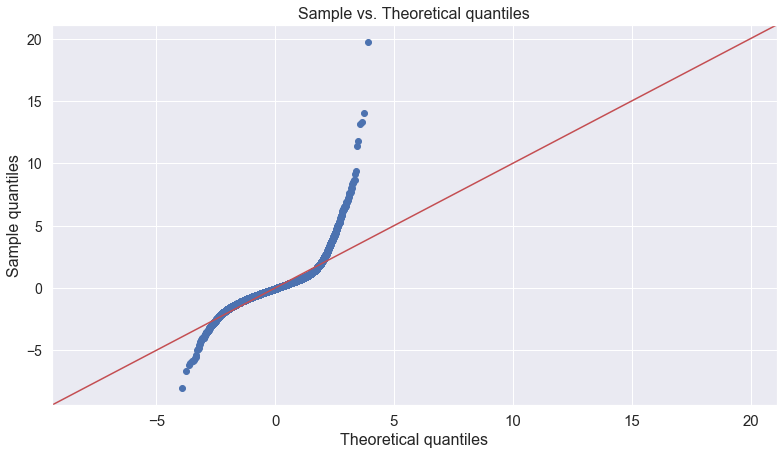

In [20]:
fig, ax = plt.subplots(figsize=(13, 7))
sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True, ax=ax)
plt.xlabel('Theoretical quantiles', fontsize=16)
plt.ylabel('Sample quantiles', fontsize=16)
plt.title('Sample vs. Theoretical quantiles', fontsize=16)
plt.xticks(fontsize=15); plt.yticks(fontsize=14);
plt.show();


#### Inference from the Q-Q plot
Ideally, this plot should show a straight line. A curved, distorted line suggests residuals have a non-normal distribution. We need to make improve the model. 

### Checking for Homoscedasticity
A scatter plot is good way to check whether the data are homoscedastic (meaning the residuals are equal across the regression line). The residuals are equal across the regression line.

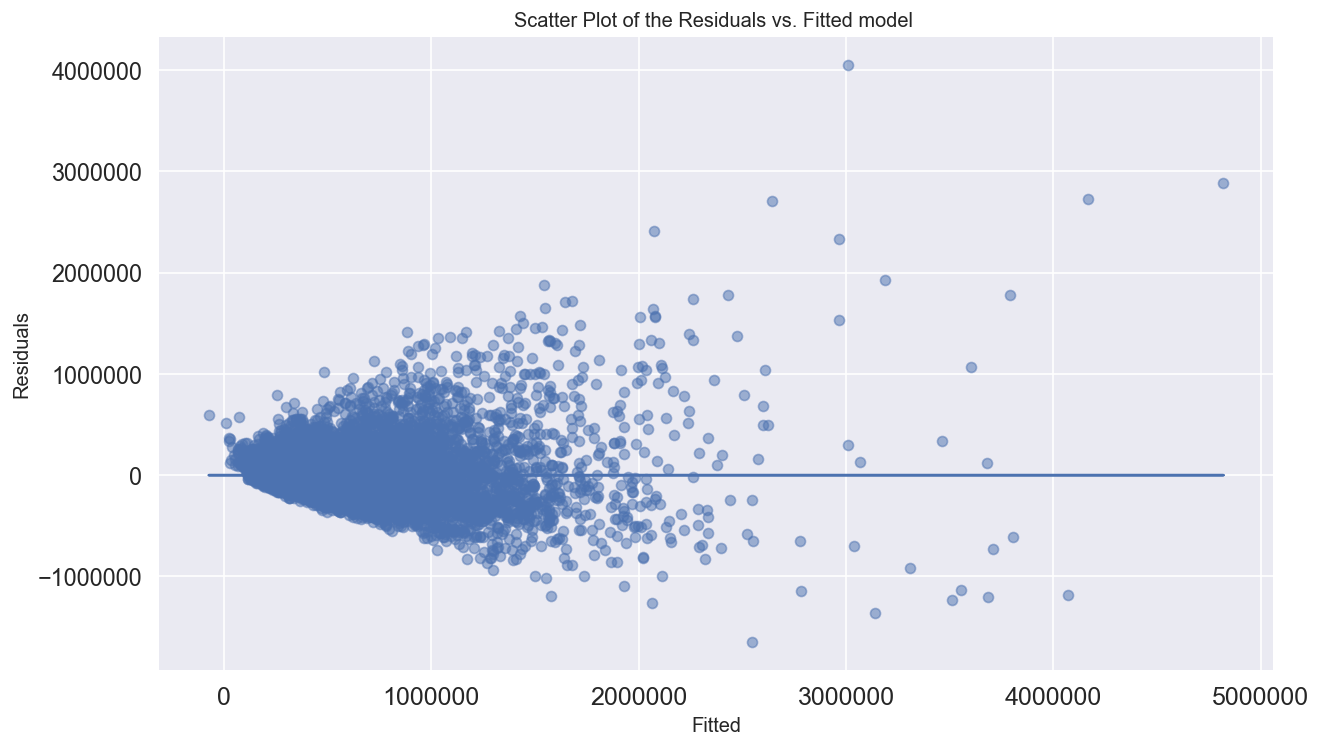

In [21]:
plt.figure(figsize=(12, 7), dpi= 120,  edgecolor='k');
plt.scatter(model.predict(df_feats[x_cols]), model.resid, alpha=0.5);
plt.plot(model.predict(df_feats[x_cols]), [0 for i in range(len(df_feats))]);
plt.gca().set(xlabel='Fitted', ylabel='Residuals',title='Scatter Plot of the Residuals vs. Fitted model ')
plt.xticks(fontsize=15); plt.yticks(fontsize=14);
plt.show();

### Checking for multicollinearity
Variance inflation factor (VIF) is a measure of the amount of multicollinearity in a set of multiple regression variables. It means that if VIF value of a parameter is higher than app.5 we need to eliminate this parameter. In this model we eliminate the parameters by using stepwise selection. We double check the results via VIF.

In [22]:
X = df_feats[x_cols]

In [23]:
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('bathrooms', 3.453558459205616),
 ('sqft_living', 147.02666039351962),
 ('sqft_lot', 2.0265202748845494),
 ('sqft_above', 119.79059862568201),
 ('sqft_basement', 33.11662465822042),
 ('yr_built', 2.52124343503991),
 ('yr_renovated', 1.1321507189421973),
 ('sqft_living15', 2.9586918647414904),
 ('sqft_lot15', 2.0545462782248727),
 ('bedrooms_2', 15.878546805584852),
 ('bedrooms_3', 56.20608165533398),
 ('bedrooms_4', 41.048515217808536),
 ('bedrooms_5', 10.668841623135975),
 ('bedrooms_6', 2.70736603681542),
 ('bedrooms_7', 1.264801009752972),
 ('bedrooms_8', 1.1019443726358449),
 ('bedrooms_9', 1.0514376506749123),
 ('bedrooms_10', 1.0215682173749954),
 ('bedrooms_11', 1.0080633126031378),
 ('floors_1_5', 1.4056968415258773),
 ('floors_2_0', 3.9787905010956264),
 ('floors_2_5', 1.0835019388780036),
 ('floors_3_0', 1.3287786923664782),
 ('floors_3_5', 1.016845543891963),
 ('waterfront_1_0', 1.503987669409899),
 ('view_1_0', 1.043792503796156),
 ('view_2_0', 1.1160982981432097),
 ('vie

#### Note: 
I tried to fit this model for hours. I made 30-40 different combinations to have satisfying p-values and R-sqared values. Finally I saw that it is not possible to make a working regression model without zip code. I avoided adding 70 more columns to the data frame. I was afraid of overfitting but I coul not even overfit the data. Zip codes worked well because I had a big sample size, having more than 100 columns did not make a problem.

## Model Refinement I

We add one categorical columns of zip code and sale month.

In [24]:
outcome = 'price'
x_cols = [ 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15',
       'sqft_lot15', 'bedrooms_2', 'bedrooms_3', 'bedrooms_4', 'bedrooms_5',
       'bedrooms_6', 'bedrooms_7', 'bedrooms_8', 'bedrooms_9', 'bedrooms_10',
       'bedrooms_11', 'floors_1_5', 'floors_2_0', 'floors_2_5', 'floors_3_0',
       'floors_3_5', 'waterfront_1_0', 'view_1_0', 'view_2_0', 'view_3_0',
       'view_4_0', 'condition_2', 'condition_3', 'condition_4', 'condition_5',
       'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9',
       'grade_10', 'grade_11', 'grade_12', 'grade_13', 'sale_month_2', 
       'sale_month_3', 'sale_month_4', 'sale_month_5', 'sale_month_6',
       'sale_month_7', 'sale_month_8', 'sale_month_9', 'sale_month_10',
       'sale_month_11', 'sale_month_12','zipcode_98002','zipcode_98014',
       'zipcode_98003', 'zipcode_98004', 'zipcode_98005', 'zipcode_98006',
       'zipcode_98007', 'zipcode_98008', 'zipcode_98010', 'zipcode_98011', 
       'zipcode_98019', 'zipcode_98022', 'zipcode_98023', 'zipcode_98024',
       'zipcode_98027', 'zipcode_98028', 'zipcode_98029', 'zipcode_98030',
       'zipcode_98031', 'zipcode_98032', 'zipcode_98033', 'zipcode_98034',
       'zipcode_98038', 'zipcode_98039', 'zipcode_98040', 'zipcode_98042',
       'zipcode_98045', 'zipcode_98052', 'zipcode_98053', 'zipcode_98055',
       'zipcode_98056', 'zipcode_98058', 'zipcode_98059', 'zipcode_98065',
       'zipcode_98070', 'zipcode_98072', 'zipcode_98074', 'zipcode_98075',
       'zipcode_98077', 'zipcode_98092', 'zipcode_98102', 'zipcode_98103',
       'zipcode_98105', 'zipcode_98106', 'zipcode_98107', 'zipcode_98108',
       'zipcode_98109', 'zipcode_98112', 'zipcode_98115', 'zipcode_98116',
       'zipcode_98117', 'zipcode_98118', 'zipcode_98119', 'zipcode_98122',
       'zipcode_98125', 'zipcode_98126', 'zipcode_98133', 'zipcode_98136',
       'zipcode_98144', 'zipcode_98146', 'zipcode_98148', 'zipcode_98155',
       'zipcode_98166', 'zipcode_98168', 'zipcode_98177', 'zipcode_98178',
       'zipcode_98188', 'zipcode_98198', 'zipcode_98199']


#### Fitting the model

We used stats models OLS regression. We put x.cols to the model and tried to predict the target parameter 'price'.

In [25]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df_feats).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     898.4
Date:                Fri, 01 May 2020   Prob (F-statistic):               0.00
Time:                        21:44:14   Log-Likelihood:            -2.8774e+05
No. Observations:               21594   AIC:                         5.757e+05
Df Residuals:                   21470   BIC:                         5.767e+05
Df Model:                         123                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       3.782e+05   1.52e+05      2.489      0.013    8.04e+04    6.76e+05
bathrooms       1.958e+04   1898.272     10.317      0.000    1.59e+04    2.33e+04
sqft_living     9.278e+04   1.23e+04      7.547      0.000    6.87e+04    1.17e+05
sqft_lot        9441.7557   1451.759      6.504      0.000    6596.199    1.23e+04
sqft_above       5.37e+04   1.11e+04      4.827      0.000    3.19e+04    7.55e+04
sqft_basement   6225.6800   5830.035      1.068      0.286   -5201.623    1.77e+04
yr_built       -7837.1201   1902.776     -4.119      0.000   -1.16e+04   -4107.538
yr_renovated    1.071e+04   1087.295      9.851      0.000    8579.291    1.28e+04
sqft_living15   1.144e+04   1862.767      6.143      0.000    7791.938    1.51e+04
sqft_lot15     -2995.3406   1504.505     -1.991      0.047   -5944.282     -46.399
bedrooms_2      4052.9234   1.13e+04      0.359      0.720   -1.81e+04    2.62e+04
bedrooms_3      2523.8539   1.13e+04      0.223      0.823   -1.96e+04    2.47e+04
bedrooms_4     -1.926e+04   1.16e+04     -1.667      0.095   -4.19e+04    3380.216
bedrooms_5     -2.932e+04   1.22e+04     -2.401      0.016   -5.33e+04   -5387.344
bedrooms_6     -4.518e+04   1.49e+04     -3.030      0.002   -7.44e+04   -1.59e+04
bedrooms_7     -1.314e+05   2.72e+04     -4.833      0.000   -1.85e+05   -7.81e+04
bedrooms_8     -1.664e+04   4.34e+04     -0.383      0.701   -1.02e+05    6.84e+04
bedrooms_9     -2.448e+05   6.25e+04     -3.918      0.000   -3.67e+05   -1.22e+05
bedrooms_10    -2.836e+05   8.69e+04     -3.265      0.001   -4.54e+05   -1.13e+05
bedrooms_11    -9.394e+04   1.49e+05     -0.629      0.530   -3.87e+05    1.99e+05
floors_1_5     -1.016e+04   4129.192     -2.462      0.014   -1.83e+04   -2070.530
floors_2_0      -2.97e+04   3472.160     -8.555      0.000   -3.65e+04   -2.29e+04
floors_2_5      4.671e+04   1.24e+04      3.761      0.000    2.24e+04     7.1e+04
floors_3_0     -7.381e+04   7690.851     -9.597      0.000   -8.89e+04   -5.87e+04
floors_3_5     -9140.4933   5.68e+04     -0.161      0.872    -1.2e+05    1.02e+05
waterfront_1_0   5.96e+05   1.53e+04     38.847      0.000    5.66e+05    6.26e+05
view_1_0        8.675e+04   8470.421     10.242      0.000    7.02e+04    1.03e+05
view_2_0        6.803e+04   5180.831     13.131      0.000    5.79e+04    7.82e+04
view_3_0        1.511e+05   7078.512     21.353      0.000    1.37e+05    1.65e+05
view_4_0        2.982e+05   1.07e+04     27.927      0.000    2.77e+05    3.19e+05
condition_2     8.712e+04      3e+04      2.900      0.004    2.82e+04    1.46e+05
condition_3     9.673e+04    2.8e+04      3.459      0.001    4.19e+04    1.52e+05
condition_4     1.214e+05    2.8e+04      4.340      0.000    6.66e+04    1.76e+05
condition_5     1.672e+05   2.81e+04      5.941      0.000    1.12e+05    2.22e+05
grade_4     

#### Inference from the model summary
Wow! We have a good R-squared value. Adjusted R- squared value is not very different from the R-squared value because the sample size is big. We have more than 27 thousand houses to fit the model. P-values of some parameters are higher than 0.05 which decreases confidence level. We need to eliminate the columns by stepwise selection.

### Checking for Normality


We should check to ensure that our residuals are normally distributed.Q-Q plots are helpful for analyzing normality.

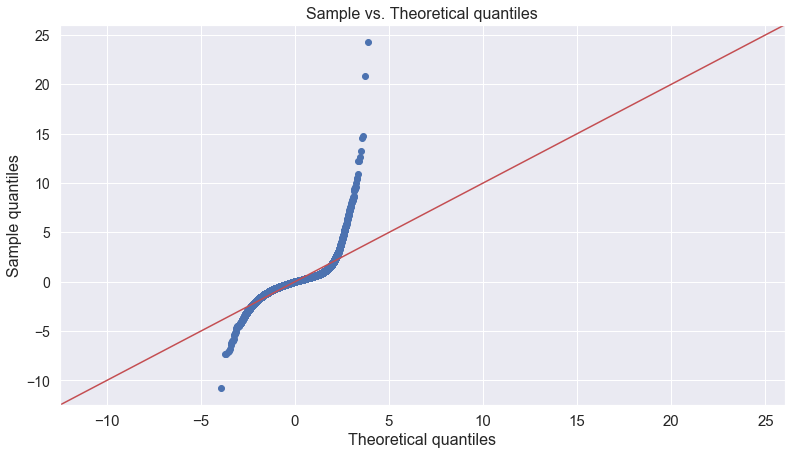

In [26]:
fig, ax = plt.subplots(figsize=(13, 7))
sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True, ax=ax)
plt.xlabel('Theoretical quantiles', fontsize=16)
plt.ylabel('Sample quantiles', fontsize=16)
plt.title('Sample vs. Theoretical quantiles', fontsize=16)
plt.xticks(fontsize=15); plt.yticks(fontsize=14);
plt.show();


#### Inference from the Q-Q plot
Ideally, this plot should show a straight line. A curved, distorted line suggests residuals have a non-normal distribution. We need to make improve the model. 

### Checking for Homoscedasticity

A scatter plot is good way to check whether the data are homoscedastic (meaning the residuals are equal across the regression line). The residuals are equal across the regression line.

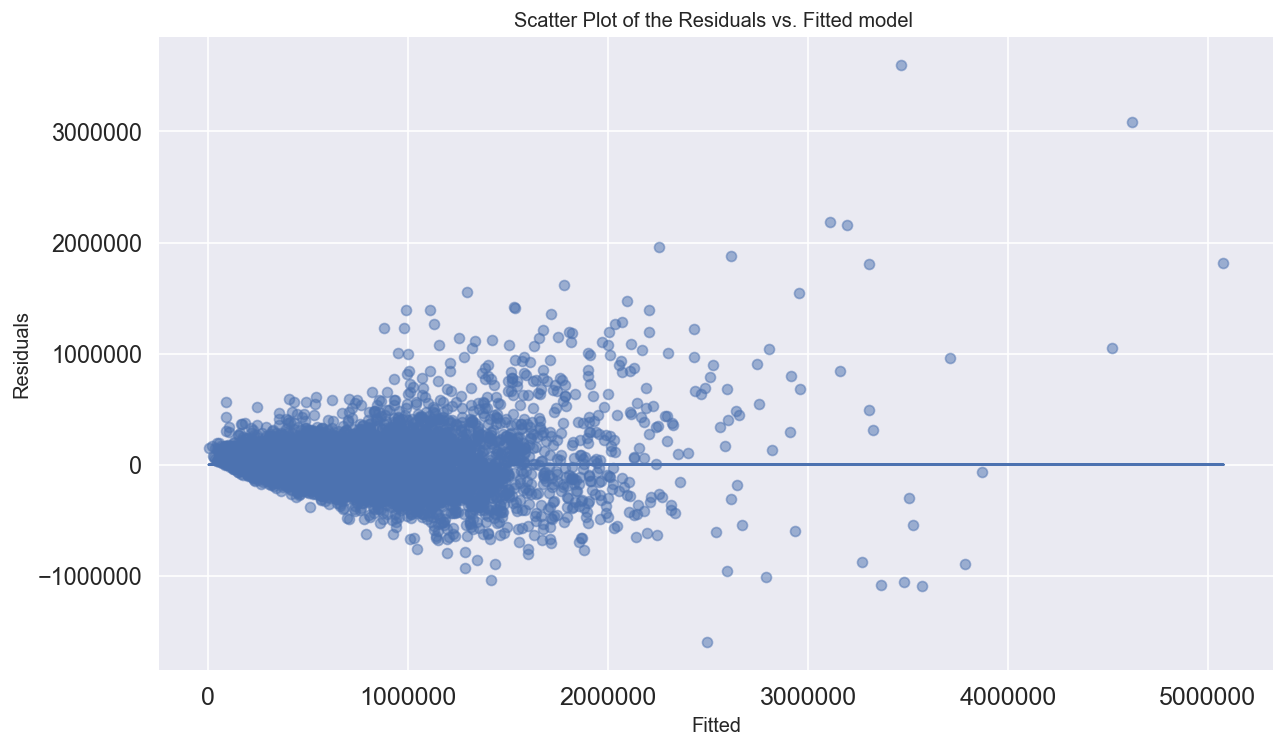

In [27]:
plt.figure(figsize=(12, 7), dpi= 120,  edgecolor='k');
plt.scatter(model.predict(df_feats[x_cols]), model.resid, alpha=0.5);
plt.plot(model.predict(df_feats[x_cols]), [0 for i in range(len(df_feats))]);
plt.gca().set(xlabel='Fitted', ylabel='Residuals',title='Scatter Plot of the Residuals vs. Fitted model ')
plt.xticks(fontsize=15); plt.yticks(fontsize=14);
plt.show();

### Checking for multicollinearity
Variance inflation factor (VIF) is a measure of the amount of multicollinearity in a set of multiple regression variables. It means that if VIF value of a parameter is higher than app.5 we need to eliminate this parameter. In this model we eliminate the parameters by using stepwise selection. We double check the results via VIF.


In [28]:
X = df_feats[x_cols]

In [29]:
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('bathrooms', 3.524589045586241),
 ('sqft_living', 147.84853873759954),
 ('sqft_lot', 2.0616569812426975),
 ('sqft_above', 121.09637509989568),
 ('sqft_basement', 33.24832412113971),
 ('yr_built', 3.540381065301067),
 ('yr_renovated', 1.15639836631501),
 ('sqft_living15', 3.394223887811644),
 ('sqft_lot15', 2.2140843540541786),
 ('bedrooms_2', 15.957200432849191),
 ('bedrooms_3', 56.8041026439203),
 ('bedrooms_4', 41.581957352573625),
 ('bedrooms_5', 10.815294555115493),
 ('bedrooms_6', 2.7397636743561278),
 ('bedrooms_7', 1.2726385947739771),
 ('bedrooms_8', 1.1085687335774737),
 ('bedrooms_9', 1.0607343630652162),
 ('bedrooms_10', 1.025598075443274),
 ('bedrooms_11', 1.0117041082811198),
 ('floors_1_5', 1.4752651701033779),
 ('floors_2_0', 4.4952976122507255),
 ('floors_2_5', 1.124982217166857),
 ('floors_3_0', 1.637046507218028),
 ('floors_3_5', 1.0231619923135764),
 ('waterfront_1_0', 1.5568215664668572),
 ('view_1_0', 1.0726002665246768),
 ('view_2_0', 1.1624138058807831),
 ('vie

#### Inference from the VIF values
According to the results here grade dummy variables are problematic. They have huge values which shows multicollinearity between columns. We will drop some of them after the stepwise selection. And check the VIF values again.

### K-fold Cross Validation for Refinement I

In [30]:
X = df_feats[x_cols]
y = df_feats['price']

linreg = LinearRegression()
cvs_10=cross_val_score(linreg, X, y, cv=10)
cvs_10_res_mean = round(np.mean(cvs_10),5)
cv_10_res_std = round(np.std(cvs_10),5)
print(f'Mean cross validation score for 10 fold is {cvs_10_res_mean}')
print(f'Standard deviation of the score is {cv_10_res_std}')

Mean cross validation score for 10 fold is -2.346940618739013e+17
Standard deviation of the score is 6.760432714901779e+17


#### Inference from the C-V results
The code above gives the mean values of the results after 10 tests with different train and test splits. These values are too high and the model is overfitted.

### Perform stepwise selection

#### Stepwise selection function

There is not a built-in function in Python libraries for stepwise selection. We are going to use this function.

In [31]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [32]:
X = df_feats[x_cols]
y = df_feats['price']
result = stepwise_selection(X, y, verbose = False)
print('resulting features:')
print(result)

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is dep

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is dep

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is dep

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is dep

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is dep

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is dep

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is dep

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is dep

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is dep

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is dep

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


resulting features:
['zipcode_98004', 'grade_11', 'sqft_above', 'yr_built', 'sqft_living15', 'waterfront_1_0', 'zipcode_98039', 'zipcode_98112', 'grade_12', 'grade_13', 'grade_10', 'grade_9', 'grade_8', 'zipcode_98040', 'zipcode_98023', 'zipcode_98033', 'bathrooms', 'view_4_0', 'zipcode_98105', 'zipcode_98119', 'zipcode_98115', 'zipcode_98103', 'zipcode_98199', 'zipcode_98117', 'zipcode_98109', 'zipcode_98107', 'zipcode_98102', 'zipcode_98122', 'zipcode_98116', 'view_3_0', 'zipcode_98092', 'zipcode_98144', 'zipcode_98052', 'zipcode_98006', 'zipcode_98008', 'zipcode_98005', 'zipcode_98136', 'zipcode_98034', 'zipcode_98053', 'zipcode_98029', 'zipcode_98125', 'zipcode_98177', 'zipcode_98126', 'condition_5', 'zipcode_98007', 'zipcode_98133', 'zipcode_98074', 'zipcode_98027', 'zipcode_98118', 'view_2_0', 'zipcode_98075', 'zipcode_98155', 'zipcode_98072', 'sale_month_4', 'view_1_0', 'sqft_lot', 'zipcode_98028', 'zipcode_98106', 'yr_renovated', 'condition_4', 'zipcode_98011', 'sale_month_3', 

## Model Refinement II


We will put the resulting features to the model and drop others. After the refinement we will check three assumptions again.

In [33]:
outcome = 'price'
x_cols = ['bathrooms', 'bedrooms_2', 'bedrooms_5', 'bedrooms_6', 'bedrooms_7', 'bedrooms_9',
           'condition_2', 'condition_3', 'condition_4', 'condition_5',
           'floors_2_0', 'floors_3_0',
           'grade_10', 'grade_11', 'grade_12', 'grade_13', 'grade_5', 'grade_7', 'grade_8', 'grade_9',
           'sale_month_2', 'sale_month_3', 'sale_month_4', 'sale_month_5',
           'sqft_above', 'sqft_basement', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15',
           'view_1_0', 'view_2_0', 'view_3_0', 'view_4_0',
           'waterfront_1_0', 'yr_renovated', 'zipcode_98002', 'zipcode_98003', 'zipcode_98004',
           'zipcode_98005', 'zipcode_98006', 'zipcode_98007', 'zipcode_98008', 'zipcode_98010',
           'zipcode_98011', 'zipcode_98014', 'zipcode_98019', 'zipcode_98023', 'zipcode_98024',
           'zipcode_98027', 'zipcode_98028', 'zipcode_98029', 'zipcode_98032', 'zipcode_98033',
           'zipcode_98034', 'zipcode_98038', 'zipcode_98039', 'zipcode_98040', 'zipcode_98045',
           'zipcode_98052', 'zipcode_98053', 'zipcode_98055', 'zipcode_98056', 'zipcode_98058',
           'zipcode_98059', 'zipcode_98065', 'zipcode_98070', 'zipcode_98072', 'zipcode_98074',
           'zipcode_98075', 'zipcode_98077', 'zipcode_98092', 'zipcode_98102', 'zipcode_98103', 
           'zipcode_98105', 'zipcode_98106', 'zipcode_98107', 'zipcode_98108', 'zipcode_98109', 
           'zipcode_98112', 'zipcode_98115', 'zipcode_98116', 'zipcode_98117', 'zipcode_98118', 
           'zipcode_98119', 'zipcode_98122', 'zipcode_98125', 'zipcode_98126', 'zipcode_98133',
           'zipcode_98136', 'zipcode_98144', 'zipcode_98146', 'zipcode_98148', 'zipcode_98155', 
           'zipcode_98166', 'zipcode_98168', 'zipcode_98177', 'zipcode_98178', 'zipcode_98188', 
           'zipcode_98199']
          

#### Fitting the model

In [34]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df_feats).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     1098.
Date:                Fri, 01 May 2020   Prob (F-statistic):               0.00
Time:                        21:50:57   Log-Likelihood:            -2.8780e+05
No. Observations:               21594   AIC:                         5.758e+05
Df Residuals:                   21493   BIC:                         5.766e+05
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.987e+05   2.83e+04      7.016      0.000    1.43e+05    2.54e+05
bathrooms       1.707e+04   1810.120      9.432      0.000    1.35e+04    2.06e+04
bedrooms_2      5684.3967   3479.503      1.634      0.102   -1135.688    1.25e+04
bedrooms_5     -1.704e+04   4176.505     -4.080      0.000   -2.52e+04   -8853.997
bedrooms_6     -2.767e+04   9420.630     -2.937      0.003   -4.61e+04   -9202.278
bedrooms_7     -1.108e+05   2.45e+04     -4.515      0.000   -1.59e+05   -6.27e+04
bedrooms_9     -2.003e+05   6.13e+04     -3.266      0.001   -3.21e+05   -8.01e+04
condition_2     8.506e+04   3.01e+04      2.826      0.005    2.61e+04    1.44e+05
condition_3     9.205e+04    2.8e+04      3.289      0.001    3.72e+04    1.47e+05
condition_4      1.19e+05    2.8e+04      4.249      0.000    6.41e+04    1.74e+05
condition_5     1.656e+05   2.82e+04      5.875      0.000     1.1e+05    2.21e+05
floors_2_0     -3.421e+04   3144.286    -10.880      0.000   -4.04e+04    -2.8e+04
floors_3_0     -8.115e+04   7104.722    -11.421      0.000   -9.51e+04   -6.72e+04
grade_10        2.165e+05   7825.178     27.669      0.000    2.01e+05    2.32e+05
grade_11        4.174e+05   1.09e+04     38.222      0.000    3.96e+05    4.39e+05
grade_12        8.266e+05   1.87e+04     44.136      0.000     7.9e+05    8.63e+05
grade_13        1.934e+06   4.36e+04     44.329      0.000    1.85e+06    2.02e+06
grade_5         6230.4527   1.03e+04      0.607      0.544   -1.39e+04    2.64e+04
grade_7        -2195.9518   3997.642     -0.549      0.583      -1e+04    5639.725
grade_8          2.06e+04   4780.903      4.308      0.000    1.12e+04       3e+04
grade_9         9.281e+04   6102.054     15.209      0.000    8.08e+04    1.05e+05
sale_month_2    9962.8943   4418.210      2.255      0.024    1302.874    1.86e+04
sale_month_3    3.197e+04   3678.001      8.693      0.000    2.48e+04    3.92e+04
sale_month_4    3.887e+04   3411.081     11.394      0.000    3.22e+04    4.56e+04
sale_month_5    8341.0619   3293.867      2.532      0.011    1884.838    1.48e+04
sqft_above      5.318e+04   1.11e+04      4.786      0.000    3.14e+04     7.5e+04
sqft_basement   5946.4967   5841.318      1.018      0.309   -5502.920    1.74e+04
sqft_living     8.915e+04   1.23e+04      7.249      0.000     6.5e+04    1.13e+05
sqft_living15   1.131e+04   1854.941      6.096      0.000    7671.161    1.49e+04
sqft_lot        9443.5358   1451.592      6.506      0.000    6598.308    1.23e+04
sqft_lot15     -2716.0451   1499.429     -1.811      0.070   -5655.038     222.948
view_1_0        8.854e+04   8468.424     10.455      0.000    7.19e+04    1.05e+05
view_2_0        7.018e+04   5160.561     13.599      0.000    6.01e+04    8.03e+04
view_3_0        1.534e+05   7054.024     21.749      0.000     1.4e+05    1.67e+05
view_4_0    

#### Inference from the model summary
The model is powerful now. It has a high R-squared and adjusted R-squared values. All of the p-values are less than 0.05.

### Checking for Normality


We should check to ensure that our residuals are normally distributed.Q-Q plots are helpful for analyzing normality.

In [35]:
X = df_feats[x_cols]

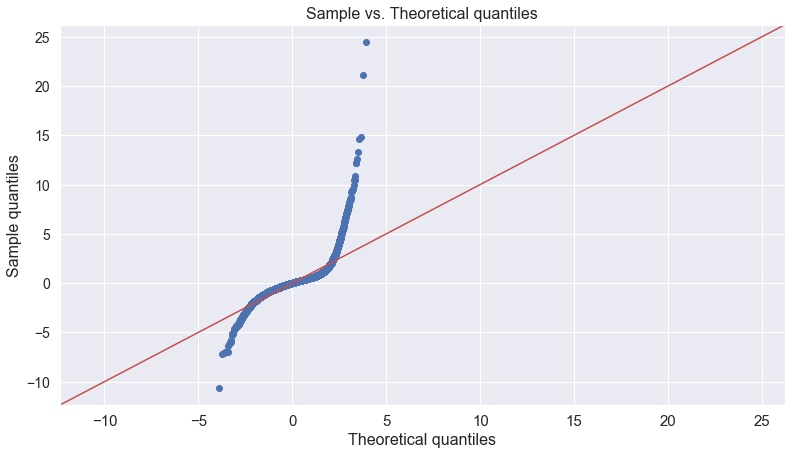

In [36]:
fig, ax = plt.subplots(figsize=(13, 7))
sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True, ax=ax)
plt.xlabel('Theoretical quantiles', fontsize=16)
plt.ylabel('Sample quantiles', fontsize=16)
plt.title('Sample vs. Theoretical quantiles', fontsize=16)
plt.xticks(fontsize=15);
plt.yticks(fontsize=14);
plt.show();

#### Infering the Q-Q plot
There is a small change in the new model. It means the residuals does not have a perfect normal distribution. But the residuals are not very far from the theoretical values.

### Checking for Homoscedasticity

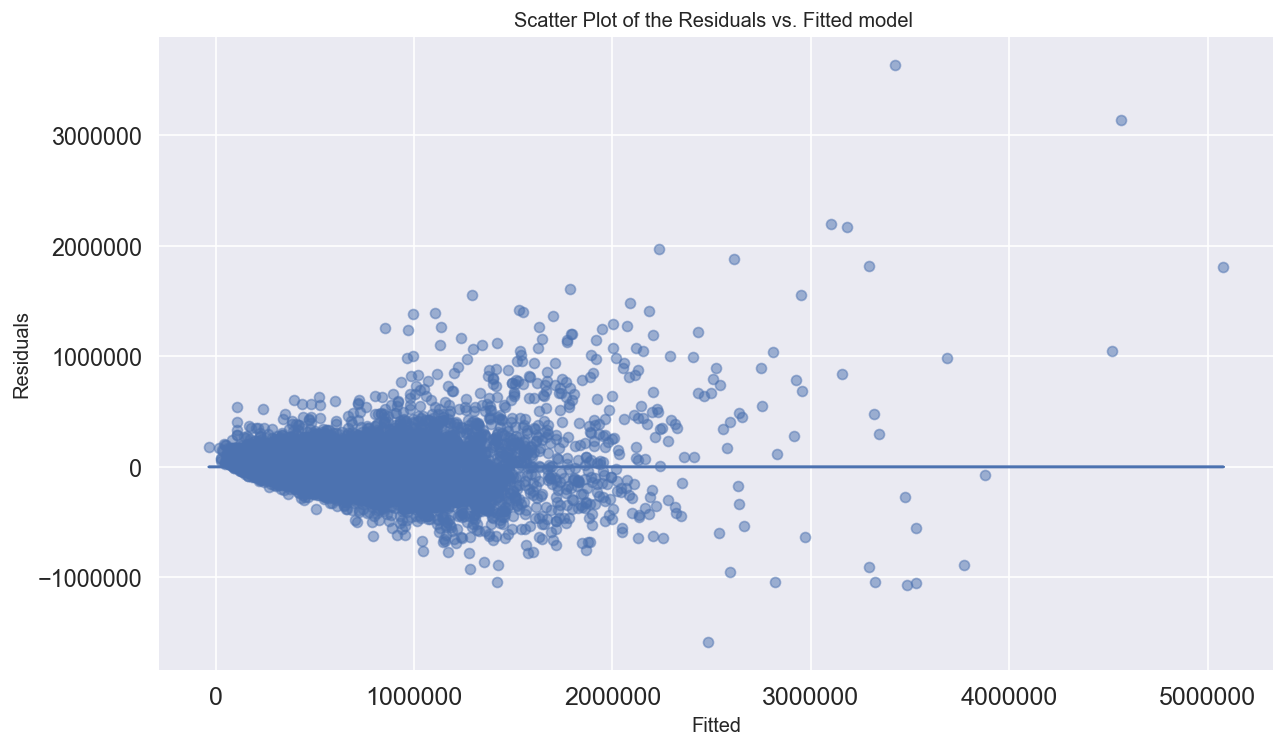

In [37]:
plt.figure(figsize=(12, 7), dpi= 120,  edgecolor='k');
plt.scatter(model.predict(df_feats[x_cols]), model.resid, alpha=0.5);
plt.plot(model.predict(df_feats[x_cols]), [0 for i in range(len(df_feats))]);
plt.gca().set(xlabel='Fitted', ylabel='Residuals',title='Scatter Plot of the Residuals vs. Fitted model ')
plt.xticks(fontsize=15); plt.yticks(fontsize=14);
plt.show();

The distribution of residuals did not change a lot after the refinement.

### Checking for Multicollinearity

In [38]:
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('bathrooms', 3.184268895309627),
 ('bedrooms_2', 1.5057604957739659),
 ('bedrooms_5', 1.2585326321119783),
 ('bedrooms_6', 1.0876078935427664),
 ('bedrooms_7', 1.0308429983036413),
 ('bedrooms_9', 1.017244463114997),
 ('condition_2', 1.1880944184768167),
 ('condition_3', 18.418401982549085),
 ('condition_4', 7.481535245836696),
 ('condition_5', 2.8821981685880402),
 ('floors_2_0', 3.6660495175253587),
 ('floors_3_0', 1.3903658080173278),
 ('grade_10', 3.1193953292793175),
 ('grade_11', 2.1296206663241994),
 ('grade_12', 1.4058692588200208),
 ('grade_13', 1.114760363853444),
 ('grade_5', 1.1335487158631996),
 ('grade_7', 6.412758575157877),
 ('grade_8', 6.207417116060453),
 ('grade_9', 4.368428212795678),
 ('sale_month_2', 1.0972304229150622),
 ('sale_month_3', 1.1423745716664537),
 ('sale_month_4', 1.1686151747448381),
 ('sale_month_5', 1.1801416849462396),
 ('sqft_above', 120.21782050313804),
 ('sqft_basement', 33.214552096824754),
 ('sqft_living', 147.20571627455854),
 ('sqft_livin

#### Inference from the  VIF values
VIF values are not too high like the first model. Stepwise selection decreased the values.

### K-fold Cross Validation for Refinement

In [39]:
linreg = LinearRegression()
cvs_10=cross_val_score(linreg, X, y, cv=10)
cvs_10_res_mean = round(np.mean(cvs_10),5)
cv_10_res_std = round(np.std(cvs_10),5)
print(f'Mean cross validation score for 10 fold is {cvs_10_res_mean}')
print(f'Standard deviation of the score is {cv_10_res_std}')


Mean cross validation score for 10 fold is 0.83055
Standard deviation of the score is 0.01199


The code above gives the mean values of the results after 10 tests with different train and test splits.

## Model Refinement III

In [40]:
outcome = 'price'
x_cols = ['bathrooms', 'bedrooms_2', 'bedrooms_5', 'bedrooms_6', 'bedrooms_7', 'bedrooms_9',
           'condition_2', 'condition_3', 'condition_4', 'condition_5',
           'floors_2_0', 'floors_3_0',
           'grade_10', 'grade_11', 'grade_12', 'grade_13', 'grade_5', 'grade_7', 'grade_8', 'grade_9',
           'sale_month_2', 'sale_month_3', 'sale_month_4', 'sale_month_5',
           'sqft_basement', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15',
           'view_1_0', 'view_2_0', 'view_3_0', 'view_4_0',
           'waterfront_1_0', 'yr_renovated', 'zipcode_98002', 'zipcode_98003', 'zipcode_98004',
           'zipcode_98005', 'zipcode_98006', 'zipcode_98007', 'zipcode_98008', 'zipcode_98010',
           'zipcode_98011', 'zipcode_98014', 'zipcode_98019', 'zipcode_98023', 'zipcode_98024',
           'zipcode_98027', 'zipcode_98028', 'zipcode_98029', 'zipcode_98032', 'zipcode_98033',
           'zipcode_98034', 'zipcode_98038', 'zipcode_98039', 'zipcode_98040', 'zipcode_98045',
           'zipcode_98052', 'zipcode_98053', 'zipcode_98055', 'zipcode_98056', 'zipcode_98058',
           'zipcode_98059', 'zipcode_98065', 'zipcode_98070', 'zipcode_98072', 'zipcode_98074',
           'zipcode_98075', 'zipcode_98077', 'zipcode_98092', 'zipcode_98102', 'zipcode_98103', 
           'zipcode_98105', 'zipcode_98106', 'zipcode_98107', 'zipcode_98108', 'zipcode_98109', 
           'zipcode_98112', 'zipcode_98115', 'zipcode_98116', 'zipcode_98117', 'zipcode_98118', 
           'zipcode_98119', 'zipcode_98122', 'zipcode_98125', 'zipcode_98126', 'zipcode_98133',
           'zipcode_98136', 'zipcode_98144', 'zipcode_98146', 'zipcode_98148', 'zipcode_98155', 
           'zipcode_98166', 'zipcode_98168', 'zipcode_98177', 'zipcode_98178', 'zipcode_98188', 
           'zipcode_98199']
          

In [41]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df_feats).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     1108.
Date:                Fri, 01 May 2020   Prob (F-statistic):               0.00
Time:                        21:51:13   Log-Likelihood:            -2.8781e+05
No. Observations:               21594   AIC:                         5.758e+05
Df Residuals:                   21494   BIC:                         5.766e+05
Df Model:                          99                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.987e+05   2.83e+04      7.012      0.000    1.43e+05    2.54e+05
bathrooms       1.672e+04   1809.526      9.240      0.000    1.32e+04    2.03e+04
bedrooms_2      5388.0774   3480.724      1.548      0.122   -1434.401    1.22e+04
bedrooms_5     -1.749e+04   4177.554     -4.188      0.000   -2.57e+04   -9306.193
bedrooms_6     -2.814e+04   9424.920     -2.985      0.003   -4.66e+04   -9661.904
bedrooms_7     -1.121e+05   2.45e+04     -4.567      0.000    -1.6e+05    -6.4e+04
bedrooms_9     -1.982e+05   6.14e+04     -3.230      0.001   -3.18e+05   -7.79e+04
condition_2     8.453e+04   3.01e+04      2.807      0.005    2.55e+04    1.44e+05
condition_3     9.194e+04    2.8e+04      3.283      0.001     3.7e+04    1.47e+05
condition_4     1.186e+05    2.8e+04      4.231      0.000    6.37e+04    1.74e+05
condition_5      1.65e+05   2.82e+04      5.851      0.000     1.1e+05     2.2e+05
floors_2_0     -3.248e+04   3125.109    -10.394      0.000   -3.86e+04   -2.64e+04
floors_3_0     -7.953e+04   7100.273    -11.200      0.000   -9.34e+04   -6.56e+04
grade_10        2.173e+05   7827.278     27.767      0.000    2.02e+05    2.33e+05
grade_11         4.19e+05   1.09e+04     38.368      0.000    3.98e+05     4.4e+05
grade_12        8.301e+05   1.87e+04     44.331      0.000    7.93e+05    8.67e+05
grade_13         1.94e+06   4.36e+04     44.467      0.000    1.85e+06    2.03e+06
grade_5         6148.4708   1.03e+04      0.599      0.549    -1.4e+04    2.63e+04
grade_7        -2410.5611   3999.427     -0.603      0.547   -1.02e+04    5428.613
grade_8         2.048e+04   4783.277      4.282      0.000    1.11e+04    2.99e+04
grade_9          9.32e+04   6104.603     15.268      0.000    8.12e+04    1.05e+05
sale_month_2    9739.9704   4420.215      2.204      0.028    1076.020    1.84e+04
sale_month_3    3.201e+04   3679.865      8.700      0.000    2.48e+04    3.92e+04
sale_month_4    3.889e+04   3412.816     11.394      0.000    3.22e+04    4.56e+04
sale_month_5    8362.2250   3295.542      2.537      0.011    1902.718    1.48e+04
sqft_basement  -2.113e+04   1451.263    -14.562      0.000    -2.4e+04   -1.83e+04
sqft_living     1.467e+05   2548.361     57.575      0.000    1.42e+05    1.52e+05
sqft_living15   1.164e+04   1854.587      6.276      0.000    8003.954    1.53e+04
sqft_lot        9567.7528   1452.099      6.589      0.000    6721.530    1.24e+04
sqft_lot15     -2799.0247   1500.093     -1.866      0.062   -5739.318     141.269
view_1_0        8.832e+04   8472.607     10.424      0.000    7.17e+04    1.05e+05
view_2_0        6.931e+04   5160.004     13.432      0.000    5.92e+04    7.94e+04
view_3_0        1.526e+05   7055.479     21.627      0.000    1.39e+05    1.66e+05
view_4_0        3.017e+05   1.07e+04     28.228      0.000    2.81e+05    3.23e+05
waterfront_1

In [42]:
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('bathrooms', 3.184268895309627),
 ('bedrooms_2', 1.5057604957739659),
 ('bedrooms_5', 1.2585326321119783),
 ('bedrooms_6', 1.0876078935427664),
 ('bedrooms_7', 1.0308429983036413),
 ('bedrooms_9', 1.017244463114997),
 ('condition_2', 1.1880944184768167),
 ('condition_3', 18.418401982549085),
 ('condition_4', 7.481535245836696),
 ('condition_5', 2.8821981685880402),
 ('floors_2_0', 3.6660495175253587),
 ('floors_3_0', 1.3903658080173278),
 ('grade_10', 3.1193953292793175),
 ('grade_11', 2.1296206663241994),
 ('grade_12', 1.4058692588200208),
 ('grade_13', 1.114760363853444),
 ('grade_5', 1.1335487158631996),
 ('grade_7', 6.412758575157877),
 ('grade_8', 6.207417116060453),
 ('grade_9', 4.368428212795678),
 ('sale_month_2', 1.0972304229150622),
 ('sale_month_3', 1.1423745716664537),
 ('sale_month_4', 1.1686151747448381),
 ('sale_month_5', 1.1801416849462396),
 ('sqft_basement', 120.21782050313804),
 ('sqft_living', 33.214552096824754),
 ('sqft_living15', 147.20571627455854),
 ('sqft_lo

In [43]:
linreg = LinearRegression()
cvs_10=cross_val_score(linreg, X, y, cv=10)
cvs_10_res_mean = round(np.mean(cvs_10),5)
cv_10_res_std = round(np.std(cvs_10),5)
print(f'Mean cross validation score for 10 fold is {cvs_10_res_mean}')
print(f'Standard deviation of the score is {cv_10_res_std}')


Mean cross validation score for 10 fold is 0.83055
Standard deviation of the score is 0.01199


In [44]:
Mean cross validation score for 10 fold is 0.88453
Standard deviation of the score is 0.00309
​

SyntaxError: invalid syntax (<ipython-input-44-0e421f840f0f>, line 1)

#### Note

First I decided not to use the date column to predict the price of a house. After I finished all the project I tried adding the month which the house was sold to see if it makes the model better. And it worked! R-squared value increased and standard deviation decreased.

These are the 10-fold Cross Validation results before I added the sale month by one hot encoding:

Mean cross validation score for 10 fold is 0.88227 and standard deviation of the score is 0.00346

Difference in the R quared values of both models: 0.88453 - 0.88227 = 0.00226

Difference in the standard deviation of both models: 0.00346 - 0.00309 = 0.00037


There is a small difference between two models but I think it worths to add date to the parameters.


# iNterpreting the data


## Answers to the Questions 

### 1) Key factors to predict the price of a house: 

The key factors affecting the price of a house are square feet of living and location. This can be seen from the pairplot above and boxplot below. In fact there are many factors to predict the price of a house. In King county housing data set we are given 17 factors to predict the price. Home buying or selling is too complicated that only 17 parameters won't give you the price of the house. Our models success is 88.453% which means we have information about the main factors to predict the price but we don't have the details. 

The factors in the last model are square footages(basement, lot and living area of the house and living and lot area of the neighbors), bedrooms, bathrooms, construction quality, renovations, view of the house, location of the house and the month house was sold.

We can have more success if we have information about the following:

Some details about grade and condition columns(Roof, AC, kitchen and bathrooms) 

The size and the condition of the garden (Every big tree adds 10K to the value)

Deck and/or patio

Energy efficiency of the house

There are some factors which we can not control. These are economic indicators and interest rates and the local market. 

We were given 20 parameters but to make a succussful prediction we need approximayetely 5 parameters about each parameter. For example, we know only the square feet of basement but we need general condition of the basement, Quality of basement finished area,Unfinished square feet of basement area, Walkout or garden level basement walls.

Predicting the price of a house requires approximetely 100 parameters.

### 2) The most important factor determining the value of a house
   

Location! Location! Location!

In the beginning I did not plan to use all zipcode columns because I thought adding 70 more columns to 40 columns would increase the R-squared value but decrease the adjusted-R-squared value. But I realised that sample size was too big. According to the mathematical formula more than 100 columns was not going to be a problem for adjusted-R-squared. After adding zip codes as dummy variables the pridictive power of my model increased a lot. I understood that the most importing prediction factor for the price of a house is location. I wanted to go further to see why some regions are more expensive.

In [ ]:
income_df=pd.read_csv('king_county_dataset_cleaned.csv')

In [ ]:
from uszipcode import SearchEngine, Zipcode

In [ ]:
search = SearchEngine(simple_zipcode=False)

In [ ]:
def zco(x):
    '''
    Takes the given zip code parameter and returns the median house income of this area.
    
    '''
    income = search.by_zipcode(x)
    
    return income.median_household_income if income else x
   

In [ ]:
income_df['income'] = income_df['zipcode'].astype(int).astype(str).apply(zco)

In [ ]:
income_df.head()

In [ ]:
fig = plt.figure(figsize = (20,8));
fig = sns.boxplot(x='zipcode', y='price', data=income_df, showfliers = False);
plt.title('Prices of Houses Sold in King County by Zip Code',fontsize=18);
plt.xlabel("Zip Code", fontsize=18);
plt.xticks(rotation=90);
plt.ylabel('Sale Price, $', fontsize=18);
plt.show();


https://www.zillow.com/bellevue-wa-98004/

https://www.zillow.com/mercer-island-wa-98040/

https://www.zillow.com/medina-wa-98039/

https://www.zillow.com/seattle-wa-98112/

In [ ]:
high_price_zipcodes=[98040,98004,98039,98112]
for i in high_price_zipcodes:
    zipcode = search.by_zipcode(i)
    income=zipcode.median_household_income
    density=zipcode.population_density
    
    print('Zip code:',i ,'-------   Median household income of all the houses in this zipcode:' ,income)

In [ ]:
zipcode = search.by_zipcode(78240)
race=zipcode.population_by_race
race

In [ ]:
zipcode = search.by_zipcode(78240)
zipcode

### 3) Home improvements

Columns in the data set:

date - Date house was sold

price - Price is prediction target

bedrooms - Number of Bedrooms/House

bathrooms - Number of bathrooms/bedrooms

sqft_living - Square footage of the home

sqft_lot - Square footage of the lot

floors - Total floors (levels) in house

waterfront - House which has a view to a waterfront

view - If the house has a view or not

condition - How good the condition is ( Overall )

grade - overall grade given to the housing unit, based on King County grading system

sqft_above - square footage of house apart from basement

sqft_basement - square footage of the basement

yr_built - Built Year

yr_renovated - Year when house was renovated

zipcode - zipcode of the house

lat - Latitude coordinate

long - Longitude coordinate

sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors

sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors


Some of these columns can not be changed after you buy a house. For example you can not change the location. Columns dependent of the location are: Latitude, Longitude,Zip code, The square footage of interior housing living space for the nearest 15 neighbors, The square footage of the land lots of the nearest 15 neighbors etc. You can not change total floors (levels) in house. 

View and waterfront also can not be changed but some improvements can be made to them. For example, a deck can be made to have a better view. A pool can be made to have a waterfront like view.

There are some columns in the dataset that we can change.Bedrooms, bathrooms,year renovated,date the house was sold  We can have more bedrooms by renovating an attic, we can have a half bathroom by converting a closet into a bathroom, you can change the finished area of the basement. Replacing the entry door or garage door, minor kitchen remodeling, adding a wooden deck, upscale siding replacement also return the money you invest for renovations.



In [ ]:
income_df.columns